In [1]:
%cd '/projects/lungbox'

/projects/lungbox


In [2]:
import os
import re

import boto3
import botocore
from io import BytesIO

import tensorflow as tf
import numpy as np
import pandas as pd

import pydicom
import gdcm
import pylab

In [3]:
s3_client = boto3.client('s3')      # low-level functional API
s3_resource = boto3.resource('s3')  # higher-level OOO API

S3_BUCKET_NAME = 'lungbox'
os.environ['AWS_REGION']='us-west-2'

S3_CLASS_INFO_KEY = 'data/raw/stage_1_detailed_class_info.csv'
S3_TRAIN_BOX_KEY = 'data/raw/stage_1_train_labels.csv'
S3_CLASS_INFO_PATH = 's3://' + S3_BUCKET_NAME + '/' + S3_CLASS_INFO_KEY
S3_TRAIN_BOX_PATH = 's3://' + S3_BUCKET_NAME + '/' + S3_TRAIN_BOX_KEY

S3_STAGE1_TRAIN_IMAGE_DIR = 'data/raw/stage_1_train_images'
S3_STAGE1_TEST_IMAGE_DIR = 'data/raw/stage_1_test_images'

In [4]:
obj_paths = []
for obj in s3_resource.Bucket(name=S3_BUCKET_NAME).objects.all():
    obj_paths.append(os.path.join(obj.bucket_name, obj.key))
print(len(obj_paths))

26688


In [5]:
# Check that all images have been uploaded
# TODO: Not efficient. Find way not to do this in a loop.
image_df = pd.DataFrame(columns=['path', 'subdir', 'patient_id'])
for obj in s3_resource.Bucket(name=S3_BUCKET_NAME).objects.all():
    path = os.path.join(obj.bucket_name, obj.key)
    if path.endswith('.dcm'):
        path_parts = path.split('/')
        image_df = image_df.append({'path': path,
                         'subdir': path_parts[3].split('_')[2], # either 'train' or 'test'
                         'patient_id': path_parts[-1].split('.')[0]},
                        ignore_index=True)

In [6]:
image_df.describe()

,path,subdir,patient_id
count,26684,26684,26684
unique,26684,2,26684
top,lungbox/data/raw/stage_1_train_images/7ff87976...,train,85a307fc-6a0c-4dd7-9402-7950496bb911
freq,1,25684,1


In [7]:
image_df.head()

,path,subdir,patient_id
0,lungbox/data/raw/stage_1_test_images/000924cf-...,test,000924cf-0f8d-42bd-9158-1af53881a557
1,lungbox/data/raw/stage_1_test_images/000db696-...,test,000db696-cf54-4385-b10b-6b16fbb3f985
2,lungbox/data/raw/stage_1_test_images/000fe35a-...,test,000fe35a-2649-43d4-b027-e67796d412e0
3,lungbox/data/raw/stage_1_test_images/001031d9-...,test,001031d9-f904-4a23-b3e5-2c088acd19c6
4,lungbox/data/raw/stage_1_test_images/0010f549-...,test,0010f549-b242-4e94-87a8-57d79de215fc


In [8]:
def read_s3_df(bucket_name, file_key):
    try:
        obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
        return pd.read_csv(obj['Body'])
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise

In [9]:
class_label_df = read_s3_df(bucket_name=S3_BUCKET_NAME, file_key=S3_CLASS_INFO_KEY)
train_box_df = read_s3_df(bucket_name=S3_BUCKET_NAME, file_key=S3_TRAIN_BOX_KEY)
print(class_label_df.iloc[:10, ])
print(train_box_df.iloc[:10, ])

                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0

In [10]:
# patient_id = train_boxes_df['patientId'][0]
patient_0 = train_box_df.loc[(train_box_df['Target'] != 0)].iloc[0]
print(print(patient_0))
print(patient_0['patientId'])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object
None
00436515-870c-4b36-a041-de91049b9ab4


In [11]:
print(S3_STAGE1_TRAIN_IMAGE_DIR + '/%s.dcm' %  patient_0['patientId'])
obj = s3_client.get_object(Bucket=S3_BUCKET_NAME,
                           Key=S3_STAGE1_TRAIN_IMAGE_DIR + '/%s.dcm' %  patient_0['patientId'])
dcm_data = pydicom.read_file(BytesIO(obj['Body'].read()))

data/raw/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm


In [12]:
print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '00436515-870c-4b36-a041-de91049b9ab4'
(0010, 0020) Patient ID                          LO: '00436515-870c-4b36-a041-de91049b9ab4'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

In [13]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype) # downsampled to 256 grayscale values
print(im.shape) # resized from 2000x2000

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

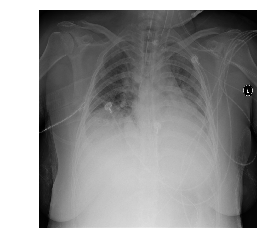

In [14]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [15]:
def parse_data(train_box_df, train_image_dirpath):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }
    
    References:
    * Exploratory Data Analysis, by Peter Chang, MD.
        - Available at https://www.kaggle.com/peterchang77/exploratory-data-analysis/notebook
        - Retrieved 2018-09-19
    """
    # Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in train_box_df.iterrows():
        # Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom_s3_key': train_image_dirpath + '%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

def get_s3_dcm(patient_id):
    obj = s3_client.get_object(Bucket=S3_BUCKET_NAME,
                               Key=S3_STAGE1_TRAIN_IMAGE_DIR + '/%s.dcm' % patient_id)
    return pydicom.read_file(BytesIO(obj['Body'].read()))

def draw(parsed_df, patient_id):
    """
    Method to draw single patient with bounding box(es) if present.
    
    References:
    * Exploratory Data Analysis, by Peter Chang, MD.
        - Available at https://www.kaggle.com/peterchang77/exploratory-data-analysis/notebook
        - Retrieved 2018-09-19
    """
    d = get_s3_dcm(patient_id)
    im = d.pixel_array

    # Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # Add boxes with random color if present
    for box in parsed_df[patient_id]['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image.
    
    References:
    * Exploratory Data Analysis, by Peter Chang, MD.
        - Available at https://www.kaggle.com/peterchang77/exploratory-data-analysis/notebook
        - Retrieved 2018-09-19
    """
    # Convert coordinates to integers
    box = [int(b) for b in box]
    
    # Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [16]:
parsed_df = parse_data(train_box_df=train_box_df,
                       train_image_dirpath=S3_STAGE1_TRAIN_IMAGE_DIR)

In [17]:
print(parsed_df['0004cfab-14fd-4e49-80ba-63a80b6bddd6'])
print(parsed_df['00436515-870c-4b36-a041-de91049b9ab4'])

{'dicom_s3_key': 'data/raw/stage_1_train_images0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', 'label': 0, 'boxes': []}
{'dicom_s3_key': 'data/raw/stage_1_train_images00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


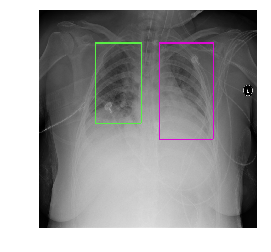

In [18]:
draw(parsed_df=parsed_df,
     patient_id='00436515-870c-4b36-a041-de91049b9ab4')

In [19]:
# smoke check: S3 files are accessible via TensorFlow
from tensorflow.python.lib.io import file_io
print(file_io.stat(S3_CLASS_INFO_PATH))

<tensorflow.python.pywrap_tensorflow_internal.FileStatistics; proxy of <Swig Object of type 'tensorflow::FileStatistics *' at 0x7fc2048bec00> >


In [23]:
filenames = ["s3://lungbox/raw/stage_1_test_images/000924cf-0f8d-42bd-9158-1af53881a557.dcm",
             "s3://lungbox/raw/stage_1_test_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm",
             "s3://lungbox/raw/stage_1_test_images/000fe35a-2649-43d4-b027-e67796d412e0.dcm",
             "s3://lungbox/raw/stage_1_test_images/001031d9-f904-4a23-b3e5-2c088acd19c6.dcm",
             "s3://lungbox/raw/stage_1_test_images/0010f549-b242-4e94-87a8-57d79de215fc.dcm"]
dataset = tf.data.TFRecordDataset(filenames)
print(dataset)

<TFRecordDataset shapes: (), types: tf.string>
